In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [2]:
df = pd.read_csv('shampoo.csv')
df.columns = ['Month', 'Sales']
df = df.dropna()

# Normalize sales
sales = df['Sales'].astype(float).values.reshape(-1, 1)
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(sales)

In [3]:
def create_window_data(sales, window_size):
    X, y = [], []
    for i in range(len(sales) - window_size):
        X.append(sales[i:i+window_size])
        y.append(sales[i+window_size])
    return np.array(X), np.array(y)

window_size = 3
X_all, y_all = create_window_data(sales_scaled, window_size)


In [4]:
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_all, y_all, test_size=0.2, shuffle=False)
X_train = torch.tensor(X_train_np.squeeze(-1), dtype=torch.float32)
X_test = torch.tensor(X_test_np.squeeze(-1), dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32).squeeze()
y_test = torch.tensor(y_test_np, dtype=torch.float32).squeeze()


In [5]:
# Train-test split
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_all, y_all, test_size=0.2, shuffle=False
)

# Fix shape from (N, window_size, 1) → (N, window_size)
X_train = torch.tensor(X_train_np.squeeze(-1), dtype=torch.float32)
X_test = torch.tensor(X_test_np.squeeze(-1), dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32).squeeze()
y_test = torch.tensor(y_test_np, dtype=torch.float32).squeeze()

Epoch 0 - Train Loss: 0.0439
Epoch 20 - Train Loss: 0.0155
Epoch 40 - Train Loss: 0.0125
Epoch 60 - Train Loss: 0.0111
Epoch 80 - Train Loss: 0.0104
Epoch 100 - Train Loss: 0.0098
Epoch 120 - Train Loss: 0.0093
Epoch 140 - Train Loss: 0.0089
Epoch 160 - Train Loss: 0.0085
Epoch 180 - Train Loss: 0.0081

Test MSE: 0.0286


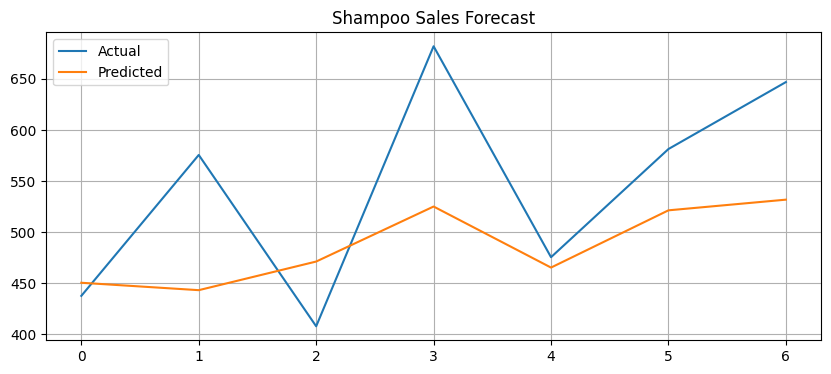

In [6]:

# Define model using Sequential
model = nn.Sequential(
    nn.Linear(window_size, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
)

# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(200):
    model.train()
    preds = model(X_train).squeeze()
    loss = loss_fn(preds, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch} - Train Loss: {loss.item():.4f}")

# Evaluation
model.eval()
with torch.inference_mode():
    test_preds = model(X_test).squeeze()
    test_loss = loss_fn(test_preds, y_test).item()

    # Inverse transform for plotting
    test_preds_np = test_preds.detach().numpy().reshape(-1, 1)
    y_test_np = y_test.detach().numpy().reshape(-1, 1)
    test_preds_inv = scaler.inverse_transform(test_preds_np)
    y_test_inv = scaler.inverse_transform(y_test_np)

print(f"\nTest MSE: {test_loss:.4f}")

plt.figure(figsize=(10, 4))
plt.plot(y_test_inv, label='Actual')
plt.plot(test_preds_inv, label='Predicted')
plt.title("Shampoo Sales Forecast")
plt.legend()
plt.grid(True)

plt.show()
